## Business scenario

In Google Merchandise Store , customers buy different swag of Google. It is also serving branding and public relationship functionality.

As the Store is operating both online and offline, it collects large amount of visit data with various perspective like user device, broswer, favourite product, etc. The sales team believe that this data asset can fuel the analytics and therefore boost the sales revenue. Since there are too many visitors, the sales team need a way to differentiate the valuable customers from pure visitors so that they can focus on maintenance of relationship with valuable customers.

The challenge is how to filter valuable customers. A reasonable way is to predict revenue per customers. The sales team want a way to differentiate customers based on their revenue prediction. 


Your team is asked to solve this problem by Data Science. You received the dataset which contains the browsing history of visitors on different products. You are going to predict the the sum of transaction of each customer

## Background & Additional Information

More info of Google Merchandise Store can be found here: [(link)](https://your.googlemerchandisestore.com/Index)

You may refer to the Kaggle page for more info [(link)](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview)

## Our dataset

Please download the dataset at https://www.kaggle.com/c/ga-customer-revenue-prediction/data

You can select either version 1 or 2 of the datasets

## Features

 - fullVisitorId: A unique identifier for each user of the Google Merchandise Store.
 - channelGrouping: The channel via which the user came to the Store.
 - date: The date on which the user visited the Store.
 - device: The specifications for the device used to access the Store.
 - geoNetwork: This section contains information about the geography of the user.
 - socialEngagementType: Engagement type, either "Socially Engaged" or "Not Socially Engaged".
 - totals: This section contains aggregate values across the session.
 - trafficSource: This section contains information about the Traffic Source from which the session originated.
 - visitId: An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
 - visitNumber: The session number for this user. If this is the first session, then this is set to 1.
 - visitStartTime: The timestamp (expressed as POSIX time).
 - hits: This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
 - customDimensions: This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
 - totals: This set of columns mostly includes high-level aggregate data.
 
## Target Variable

the **target variable** you are going to predict the natural log of *the sum of all transaction revenue* per user. You can refer to the [Kaggle page](https://www.kaggle.com/c/ga-customer-revenue-prediction/data) for more information.

## Remark

You are encouraged to read some kernels from Kaggle. However, please don't directly copy everything from the kernels.

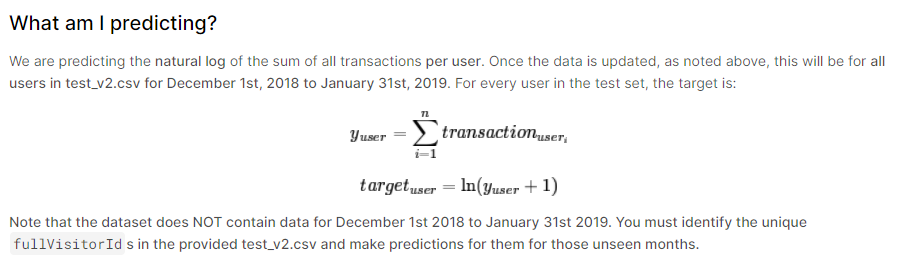

# Step 1: Data collection

The dataset is provided by Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction/data


In [5]:
# load Libraries

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from scipy import stats

# pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
# import bq_helper

import seaborn as sns 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings('ignore')

# Make print quality look significantly better. 

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")
%matplotlib inline

pd.set_option('display.max_columns', None)

def load_df(csv_path='C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [7]:
# Load tran data and see how much time took

# train = load_df()
# train.to_csv(r'C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\train_local_copy.csv')
train = pd.read_csv('C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\train_local_copy.csv')

#### <font color=red>As the dataset is large, you can sample from the original dataset with the following code:</font> 

In [8]:
# sample train
from numpy import random
random.seed(2021)

visitors = train['fullVisitorId'].unique()
selected_visitors = random.choice(visitors, size = int(visitors.shape[0] * 0.1), replace = False)

sample_train = train[train['fullVisitorId'].isin(selected_visitors)]

In [9]:
sample_train.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
5,5,Organic Search,20160902,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,1472807194,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,fastwebnet.it,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Organic Search,20160902,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,1472817241,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southern Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,21,Organic Search,20160902,6098154234696452861,6098154234696452861_1472863754,Not Socially Engaged,1472863754,1,1472863754,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Europe,Western Europe,Germany,(not set),(not set),(not set),not available in demo dataset,live-servers.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),baidu,organic,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,22,Organic Search,20160902,3323434834508685818,3323434834508685818_1472872530,Not Socially Engaged,1472872530,1,1472872530,Safari,not available in 

# Step 2: Data exploration

### Setup

First, you need to import the necessary library

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Make print quality look significantly better.
%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

%matplotlib inline

In [6]:
sample_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90413 entries, 5 to 903642
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         90413 non-null  int64  
 1   channelGrouping                                    90413 non-null  object 
 2   date                                               90413 non-null  int64  
 3   fullVisitorId                                      90413 non-null  object 
 4   sessionId                                          90413 non-null  object 
 5   socialEngagementType                               90413 non-null  object 
 6   visitId                                            90413 non-null  int64  
 7   visitNumber                                        90413 non-null  int64  
 8   visitStartTime                                     90413 non-null  int64  
 9   devic

In [11]:
# library of datetime
# change the datetime into 4 variables weekday month year and day
from datetime import datetime

# This function is to extract date features
def date_process(sample_train):
    sample_train["date"] = pd.to_datetime(sample_train["date"], format="%Y%m%d") # seting the column as pandas datetime
    sample_train["_weekday"] = sample_train['date'].dt.weekday #extracting week day
    sample_train["_day"] = sample_train['date'].dt.day # extracting day
    sample_train["_month"] = sample_train['date'].dt.month # extracting day
    sample_train["_year"] = sample_train['date'].dt.year # extracting day
    # get visit hour
    sample_train['_visitHour'] = (sample_train['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return sample_train #returning the df after the transformations

In [12]:
sample_train = date_process(sample_train) 
sample_train.head(n=10) 

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode,_weekday,_day,_month,_year,_visitHour
5,5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,1472807194,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,fastwebnet.it,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,17
6,6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,1472817241,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southern Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,19
21,21,Organic Search,2016-09-02,6098154234696452861,6098154234696452861_1472863754,Not Socially Engaged,1472863754,1,1472863754,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Europe,Western Europe,Germany,(not set),(not set),(not set),not available in demo dataset,live-servers.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),baidu,organic,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,8
22,22,Organic Search,2016-09-02,3323434834508685818,3323434834508

In [13]:
# VisitStartTime is stored in epoch unix format and should be converted to pandas datetime format. doing the correspondence transforms and storing on the same attribute.
sample_train["visitStartTime"] = pd.to_datetime(sample_train["visitStartTime"],unit='s')
sample_train.head(1)[["date","visitStartTime"]]

,date,visitStartTime
5,2016-09-02,2016-09-02 09:06:34


In [14]:
##Date Range

print(sample_train['date'].min())
print(sample_train['date'].max())

2016-08-01 00:00:00
2017-08-01 00:00:00


In [15]:
sample_train.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode,_weekday,_day,_month,_year,_visitHour
5,5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,2016-09-02 09:06:34,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,fastwebnet.it,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,17
6,6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,2016-09-02 11:54:01,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southern Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,19
21,21,Organic Search,2016-09-02,6098154234696452861,6098154234696452861_1472863754,Not Socially Engaged,1472863754,1,2016-09-03 00:49:14,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Europe,Western Europe,Germany,(not set),(not set),(not set),not available in demo dataset,live-servers.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),baidu,organic,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,8
22,22,Organic Search,2016-09-02,332343

### Plot the distribution of target variable

In [16]:
sample_train['totals.transactionRevenue'] = sample_train['totals.transactionRevenue'].astype(float)

<AxesSubplot:xlabel='totals.transactionRevenue', ylabel='Density'>

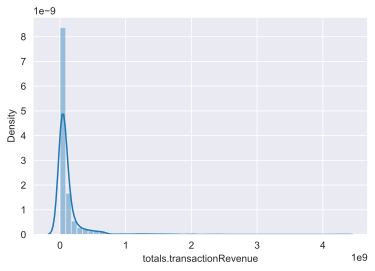

In [17]:
sns.distplot(sample_train['totals.transactionRevenue'])

#### Log Revenue Distribution

In [18]:
#Rename Column
sample_train.rename(columns={'totals.transactionRevenue':'revenue'}, inplace=True)
sample_train['logRevenue']=np.log(sample_train['revenue'])
sample_train['log1pRevenue']=np.log1p(sample_train['revenue'])

In [19]:
rev_user=(
    sample_train.filter(['fullVisitorId','_year','_month','_day','revenue',])
    .groupby(['fullVisitorId','_year'])
    .agg({"revenue": "mean"})
    .reset_index()
    .sort_values(['revenue'],ascending=False)
    .query("(revenue>= 0)")
    )

rev_user['logRevenue']=np.log(rev_user['revenue'])

rev_user.head()   

,fullVisitorId,_year,revenue,logRevenue
30773,3769632740374536577,2017,4.272000e+09,22.175348
2001,95747507496204221,2017,2.365500e+09,21.584255
16214,1410336440849356236,2016,1.995000e+09,21.413910
38667,5082563130101167793,2017,1.746820e+09,21.281063
22995,2496439703637913793,2016,1.679790e+09,21.241935


Text(0.5, 1.0, 'Distribuition of Revenue Log')

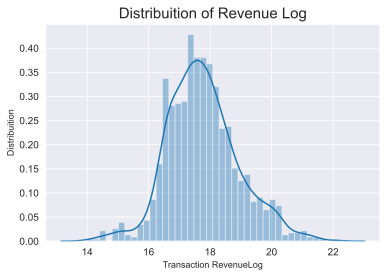

In [20]:
# normalized the log revenue
ax = sns.distplot(np.log(sample_train[sample_train['revenue'] > 0]["revenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize=9) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=9) #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=15) #seting the title and size of font


#### Revenure Value Distribution

### Hist Plot of Revenue Distribution

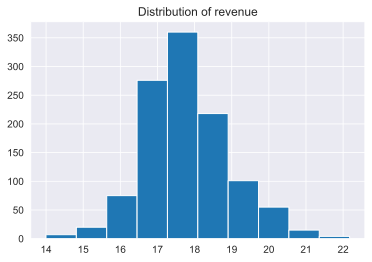

In [30]:
plt.hist(np.log1p(sample_train.loc[sample_train['revenue'].isna() == False, 'revenue']));
plt.title('Distribution of revenue');

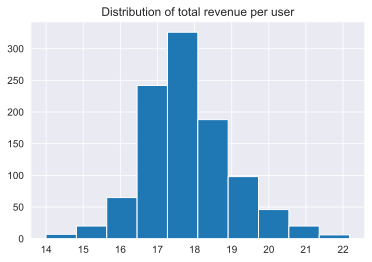

In [31]:
grouped = sample_train.groupby('fullVisitorId')['revenue'].sum().reset_index()
grouped = grouped.loc[grouped['revenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['revenue'] > 0, 'revenue']));
plt.title('Distribution of total revenue per user');

In [32]:
counts = sample_train.loc[sample_train['revenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(np.sum(counts == 1), 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of non-zero transactions per user:')
counts.head(10)

print('Most paying users made only 1 transaction, but there are several users, who had a lot of transactions.')

There are 1018 paying users (723803 total) in train data.
928 users (91.1591% of paying) have 1 paid transaction.
74 users (7.2692% of paying) have 2 paid transaction.

Count of non-zero transactions per user:
Most paying users made only 1 transaction, but there are several users, who had a lot of transactions.


### Trends of transactions number by paying  users

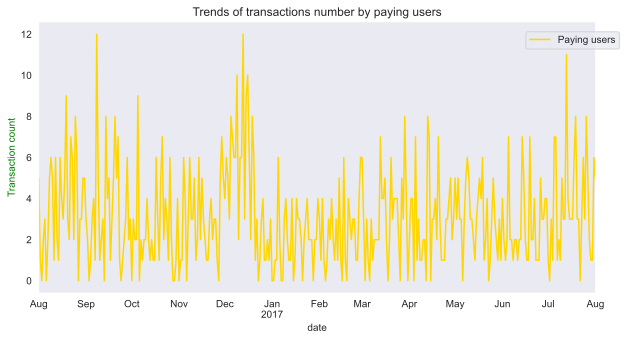

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title("Trends of transactions number by paying users");
sample_train.groupby(['date'])['revenue'].count().plot(color='gold')
ax1.set_ylabel('Transaction count', color='g')
plt.legend(['Paying users'], loc=(0.875, 0.9))
plt.grid(False)

In [35]:
revenue_datetime_df = sample_train[["revenue" , "date"]].dropna()
revenue_datetime_df['revenue']=sample_train["revenue" ]
revenue_datetime_df["revenue"] = revenue_datetime_df.revenue.astype(np.int64)

revenue_datetime_df.head()

,revenue,date
1008,339030000,2016-09-02
1055,25680000,2016-09-02
3381,236790000,2017-01-26
3394,30390000,2017-01-26
6730,300350000,2017-06-23


In [36]:
##Total Revenue per day
total_revenue_daily_df = revenue_datetime_df.groupby(by=["date"],axis=0).sum()
total_revenue_daily_df.sort_values(by=['date']).head()

,revenue
date,
2016-08-01,397780000
2016-08-02,27190000
2016-08-04,71970000
2016-08-05,128860000
2016-08-07,51670000


In [37]:
#Total Number of visits per day
total_visitNumber_daily_df = sample_train[["date","visitNumber"]].groupby(by=["date"],axis=0).sum()
total_visitNumber_daily_df.head()

,visitNumber
date,
2016-08-01,589
2016-08-02,525
2016-08-03,642
2016-08-04,764
2016-08-05,412


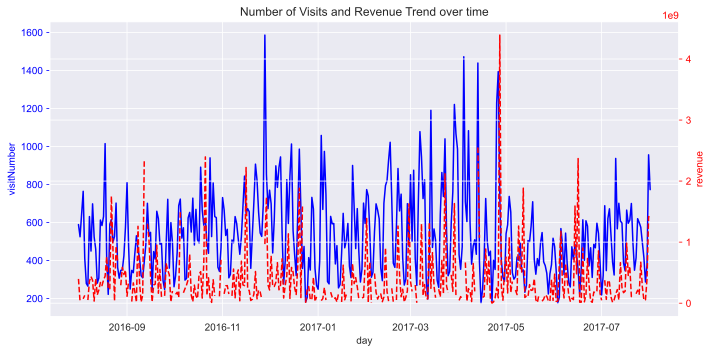

In [38]:
datetime_revenue_visits_df = pd.concat([total_revenue_daily_df,total_visitNumber_daily_df],axis=1)

fig, ax1 = plt.subplots(figsize=(10,5))
plt.title("Number of Visits and Revenue Trend over time");
t = datetime_revenue_visits_df.index
s1 = datetime_revenue_visits_df["visitNumber"]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('day')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('visitNumber', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = datetime_revenue_visits_df["revenue"]
ax2.plot(t, s2, 'r--')
ax2.set_ylabel('revenue', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

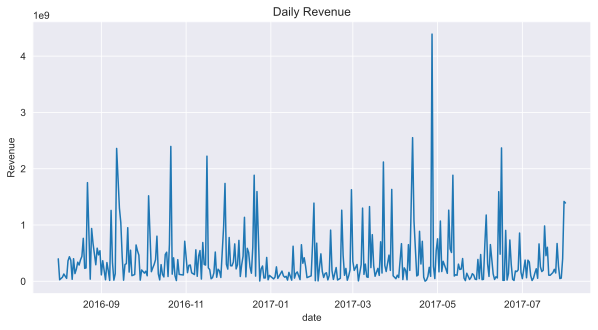

In [39]:
daily_revenue_df = revenue_datetime_df.groupby(by=["date"],axis = 0 ).sum()
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10,5))
axes.set_title("Daily Revenue")
axes.set_ylabel("Revenue")
axes.set_xlabel("date")
axes.plot(daily_revenue_df["revenue"])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1efcdf3da48>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1efcdf2e988>,
 'cmins': <matplotlib.collections.LineCollection at 0x1efcdf1aa88>,
 'cbars': <matplotlib.collections.LineCollection at 0x1efcdf79c08>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1efcdf7c248>}

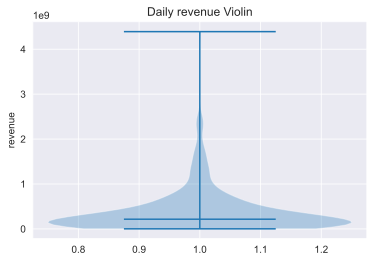

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
axes.set_title("Daily revenue Violin")
axes.set_ylabel("revenue")
axes.violinplot(list(daily_revenue_df["revenue"].values),showmeans=False,showmedians=True)

### Statistics of Dataset

In [41]:
print("Transaction Revenue Min Value: ", 
      sample_train[sample_train['revenue'] > 0]["revenue"].min()) # printing the min value
print("Transaction Revenue Mean Value: ", 
      sample_train[sample_train['revenue'] > 0]["revenue"].mean()) # mean value
print("Transaction Revenue Median Value: ", 
      sample_train[sample_train['revenue'] > 0]["revenue"].median()) # median value
print("Transaction Revenue Max Value: ", 
      sample_train[sample_train['revenue'] > 0]["revenue"].max()) # the max value


#y_clf = (sample_train['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
#y_clf.mean()

Transaction Revenue Min Value:  1200000.0
Transaction Revenue Mean Value:  114089398.76215738
Transaction Revenue Median Value:  47790000.0
Transaction Revenue Max Value:  4272000000.0


In [42]:
sample_train.visitNumber.describe()

count    90413.000000
mean         2.194806
std          7.551613
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        248.000000
Name: visitNumber, dtype: float64

In [43]:
"80 percent of sessions have visitNumber lower than {} times.".format(np.percentile(list(sample_train.visitNumber),80))

'80 percent of sessions have visitNumber lower than 2.0 times.'

In [44]:
vn = train["visitNumber"].value_counts()
def vn_bins(x):
    if x == 1:
        return "1" 
    elif x < 5:
        return "2-5"
    elif x < 10:
        return "5-10"
    elif x < 50:
        return "10-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"
    
vn = train["visitNumber"].apply(vn_bins).value_counts()
trace1 = go.Bar(y = vn.index[::-1], orientation="h" , x = vn.values[::-1], marker=dict(color="#7af9ad"))
layout = go.Layout(title="Visit Numbers Distribution", 
                   xaxis=dict(title="Frequency"),yaxis=dict(title="VisitNumber") ,
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

(array([7.0291e+04, 1.2992e+04, 3.0130e+03, 1.9810e+03, 8.6100e+02,
        5.7900e+02, 3.1200e+02, 1.6400e+02, 1.6000e+02, 6.0000e+01]),
 array([0.        , 0.55134287, 1.10268575, 1.65402862, 2.2053715 ,
        2.75671437, 3.30805725, 3.85940012, 4.410743  , 4.96208587,
        5.51342875]),
 <BarContainer object of 10 artists>)

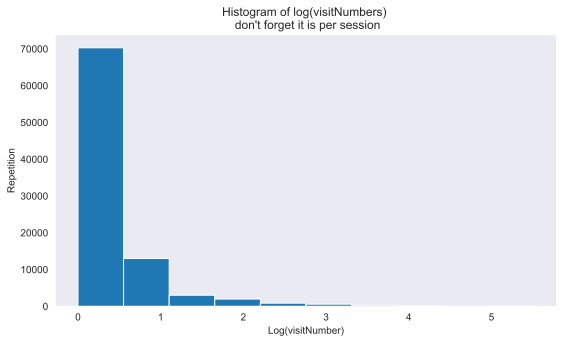

In [45]:
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.set_title("Histogram of log(visitNumbers) \n don't forget it is per session")
ax.set_ylabel("Repetition")
ax.set_xlabel("Log(visitNumber)")
ax.grid(color='b', linestyle='-', linewidth=0.1)
ax.hist(np.log(sample_train.visitNumber))

In [46]:
sample_train.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,revenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode,_weekday,_day,_month,_year,_visitHour,logRevenue,log1pRevenue
5,5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,2016-09-02 09:06:34,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,fastwebnet.it,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,17,NaN,NaN
6,6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,2016-09-02 11:54:01,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southern Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,19,NaN,NaN
21,21,Organic Search,2016-09-02,6098154234696452861,6098154234696452861_1472863754,Not Socially Engaged,1472863754,1,2016-09-03 00:49:14,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Europe,Western Europe,Germany,(not set),(not set),(not set),not available in demo dataset,live-servers.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),baidu,organic,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,8,NaN,NaN
22,22,Or

#### How many Repeat Users do we have ?
We would like to discover if repetative users tend to buy more or less

In [47]:
import collections

repetitive_users = list(np.sort(list(collections.Counter(list(sample_train["fullVisitorId"])).values())))
"25% percentile: {}, 50% percentile: {}, 75% percentile: {}, 88% percentile: {}, 88% percentile: {}".format(
np.percentile(repetitive_users,q=25),np.percentile(repetitive_users,q=50),
np.percentile(repetitive_users,q=75),np.percentile(repetitive_users,q=88), np.percentile(repetitive_users,q=89))
print('only 12 percent of users are repetitive and visited the website more than once')

only 12 percent of users are repetitive and visited the website more than once


### Channel grouping analysis:
no.of visits and transactions that are happening through each channel :

Percentual of Channel Grouping: 
Organic Search    38104
Social            22720
Direct            14190
Referral          10545
Paid Search        2524
Affiliates         1678
Display             641
(Other)              11
Name: channelGrouping, dtype: int64
90413


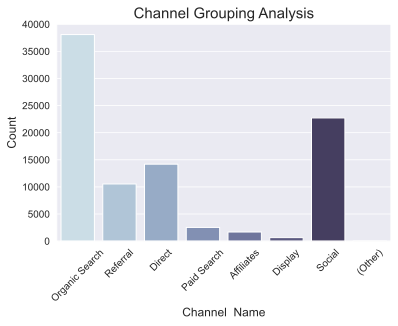

In [48]:
print("Percentual of Channel Grouping: ")
print(sample_train['channelGrouping'].value_counts()[:10] )
print(sample_train['channelGrouping'].value_counts().sum() )

sns.countplot(sample_train[sample_train['channelGrouping']\
                       .isin(sample_train['channelGrouping']\
                             .value_counts()[:10].index.values)]['channelGrouping'], palette="ch:s=.25,rot=-.25") # It's a module to count the category's
plt.title("Channel Grouping Analysis", fontsize=15) 
plt.xlabel("Channel  Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

In [49]:
# Channel grouping

tmp = train["channelGrouping"].value_counts()
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
trace = go.Pie(labels=tmp.index, values=tmp.values, marker=dict(colors=colors))
layout = go.Layout(title="Channel Grouping", height=400)
fig = go.Figure(data = [trace], layout = layout)
iplot(fig, filename='basic_pie_chart')

In [50]:
# Traffic Attributes

fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["TrafficSource Campaign (not-set removed)", "TrafficSource Medium"], print_grid=False)

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = train["trafficSource.campaign"].value_counts()
t2 = train["trafficSource.medium"].value_counts()
tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[3]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))
tr3 = go.Bar(x = t1.index[1:], y = t1.values[1:], marker=dict(color=colors[0]))
tr4 = go.Bar(x = t2.index[1:], y = t2.values[1:])

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

### Web-browser analysis :
no.of visits and transactions that are happening through each web-browser 

Percentual of Browser usage: 
Chrome               62048
Safari               18151
Firefox               3626
Internet Explorer     2028
Edge                  1052
Android Webview        748
Safari (in-app)        695
Opera Mini             618
Opera                  586
UC Browser             276
Name: device.browser, dtype: int64
90413


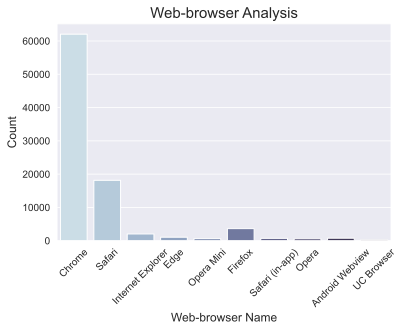

In [51]:
print("Percentual of Browser usage: ")
print(sample_train['device.browser'].value_counts()[:10] )
print(sample_train['device.browser'].value_counts().sum() )

sns.countplot(sample_train[sample_train['device.browser']\
                       .isin(sample_train['device.browser']\
                             .value_counts()[:10].index.values)]['device.browser'], palette="ch:s=.25,rot=-.25") # It's a module to count the category's
plt.title("Web-browser Analysis", fontsize=15) 
plt.xlabel("Web-browser Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

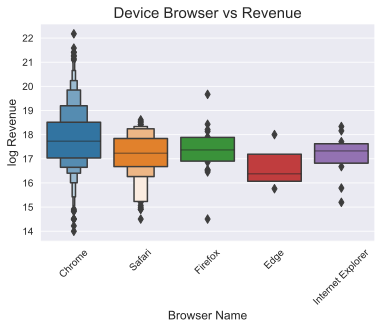

In [52]:
sns.boxenplot(x='device.browser', y='logRevenue',data= sample_train[(sample_train['device.browser'].isin((sample_train['device.browser'].value_counts()[:10].index.values))) &
                                  sample_train['revenue'] > 0])
plt.xticks(rotation=45) 
plt.title("Device Browser vs Revenue", fontsize=15) 
plt.xlabel("Browser Name", fontsize=12)
plt.ylabel("log Revenue", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

In [53]:

device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(device_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=500, showlegend=False, title="Visits by Device Attributes")
iplot(fig)



## convert transaction revenue to float

train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)

colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(device_cols):
    tmp = train.groupby(col).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=500, showlegend=False, title="Mean Revenue by Device Attributes")
iplot(fig)

### Operating System analysis:
No.of visits and transactions that are happening through each operating system

Percentual of Operating System usage: 
Windows          35190
Macintosh        25125
Android          12297
iOS              10763
Linux             3651
Chrome OS         2707
(not set)          461
Windows Phone      119
Samsung             38
BlackBerry          32
Name: device.operatingSystem, dtype: int64
90413


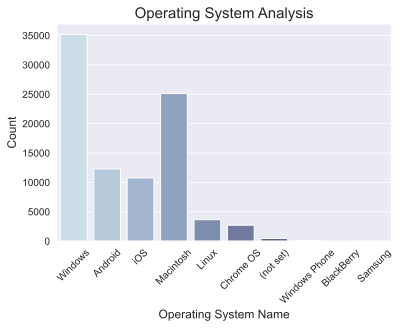

In [54]:
print("Percentual of Operating System usage: ")
print(sample_train['device.operatingSystem'].value_counts()[:10] )

print(sample_train['device.operatingSystem'].value_counts().sum() )

sns.countplot(sample_train[sample_train['device.operatingSystem']\
                       .isin(sample_train['device.operatingSystem']\
                             .value_counts()[:10].index.values)]['device.operatingSystem'], palette="ch:s=.25,rot=-.25") # It's a module to count the category's
plt.title("Operating System Analysis", fontsize=15) 
plt.xlabel("Operating System Name", fontsize=12)
plt.ylabel("Count", fontsize=12) 
#plt.bar_label(, label_type='center')
plt.xticks(rotation=45) 
plt.show() 

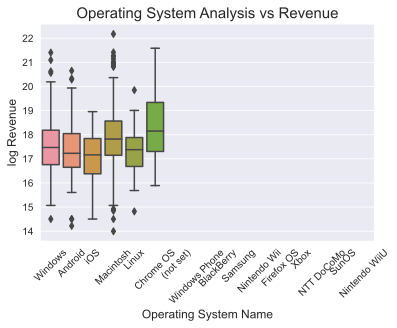

In [55]:
sns.boxplot(x='device.operatingSystem', y='logRevenue',data= sample_train)
plt.xticks(rotation=45) 
plt.title("Operating System Analysis vs Revenue", fontsize=15) 
plt.xlabel("Operating System Name", fontsize=12)
plt.ylabel("log Revenue", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

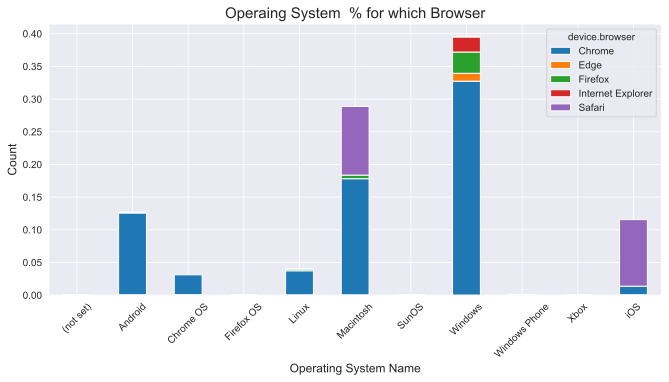

In [56]:

crosstab_eda = pd.crosstab(index=sample_train['device.operatingSystem'], normalize=True,
                           # top 5 of browsers
                           columns=sample_train[sample_train['device.browser'].isin(sample_train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_eda.plot(kind="bar",    
                 figsize=(11,5), 
                 stacked=True)   
plt.title("Operaing System  % for which Browser", fontsize=15)
plt.xlabel("Operating System Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

#### Revenue Allocation by Year

Text(0.5, 1.0, 'Revenue Allocation by Year')

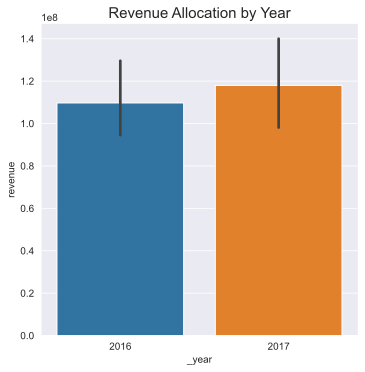

In [57]:
sns.factorplot(x= '_year', y= 'revenue', data= sample_train, kind= 'bar')
plt.title("Revenue Allocation by Year", fontsize=15) 

#### Revenue Allocation by Month

Text(0.5, 1.0, 'Revenue Allocation by Month')

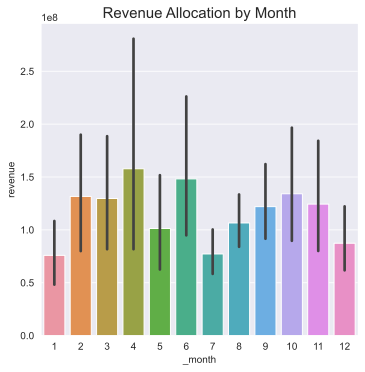

In [58]:
sns.factorplot(x= '_month', y= 'revenue', data= sample_train, kind= 'bar')
plt.title("Revenue Allocation by Month", fontsize=15) 

In [59]:
sample_train.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
  

### Channel Grouping % for which Browser

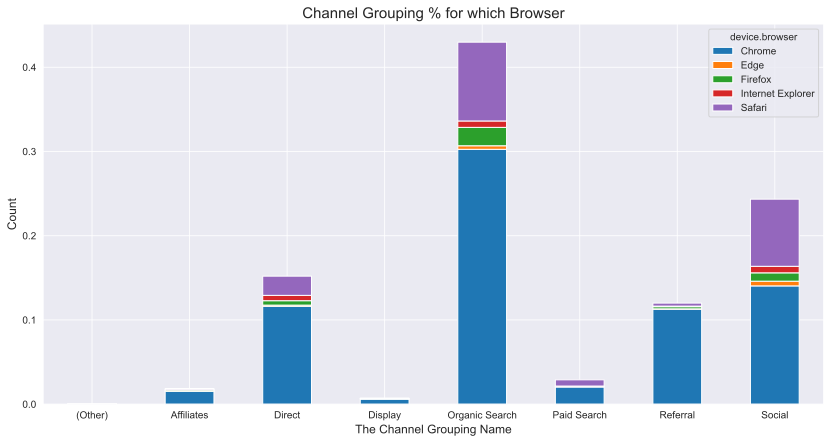

In [60]:

crosstab_eda = pd.crosstab(index=sample_train['channelGrouping'], normalize=True,
                           # top 5 of browsers
                           columns=sample_train[sample_train['device.browser'].isin(sample_train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_eda.plot(kind="bar",    
                 figsize=(14,7), 
                 stacked=True)   
plt.title("Channel Grouping % for which Browser", fontsize=15)
plt.xlabel("The Channel Grouping Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=0)
plt.show() 

### Mobile vs non-mobile analysis:
no.of visits and transactions that are happening through mobile and non-mobile devices:

### Device category analysis:
no.of visits and transactions that are happening through each device category

Percentual of Device Category usage: 
desktop    66546
mobile     20845
tablet      3022
Name: device.deviceCategory, dtype: int64
90413


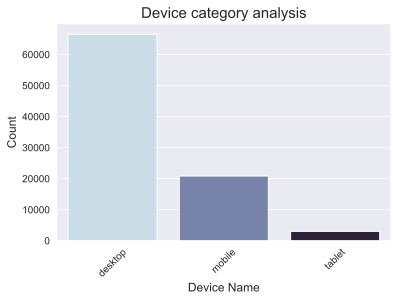

In [61]:
print("Percentual of Device Category usage: ")
print(sample_train['device.deviceCategory'].value_counts()[:3] )

print(sample_train['device.deviceCategory'].value_counts().sum() )

sns.countplot(sample_train[sample_train['device.deviceCategory']\
                       .isin(sample_train['device.deviceCategory']\
                             .value_counts()[:5].index.values)]['device.deviceCategory'], palette="ch:s=.25,rot=-.25") 
plt.title("Device category analysis", fontsize=15) 
plt.xlabel("Device Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

<AxesSubplot:xlabel='device.deviceCategory', ylabel='revenue'>

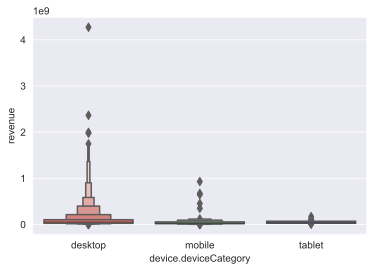

In [62]:
sns.boxenplot(x="device.deviceCategory", y = 'revenue', 
              data=sample_train[sample_train['revenue'] > 0], palette="hls")

### Continent analysis :
no.of visits and transactions that are happening through each continent :

Percentual of usage per Continent: 
Americas    44885
Asia        22523
Europe      19882
Oceania      1503
Africa       1477
Name: geoNetwork.continent, dtype: int64
90413


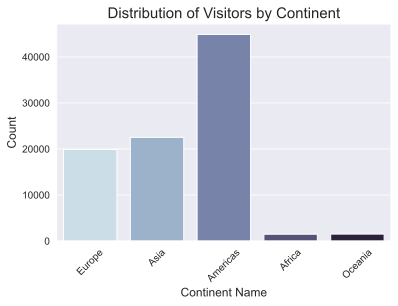

In [63]:
print("Percentual of usage per Continent: ")
print(sample_train['geoNetwork.continent'].value_counts()[:5] )

print(sample_train['geoNetwork.continent'].value_counts().sum() )
import matplotlib.pyplot as plt
sns.countplot(sample_train[sample_train['geoNetwork.continent']\
                       .isin(sample_train['geoNetwork.continent']\
                             .value_counts()[:5].index.values)]['geoNetwork.continent'], palette="ch:s=.25,rot=-.25")
plt.title("Distribution of Visitors by Continent", fontsize=15) 
plt.xlabel("Continent Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=45) 
plt.show() 

In [64]:
# Geopgraphical Analysis-part1 

geo_cols = ['geoNetwork.city', 'geoNetwork.continent','geoNetwork_.country',
            'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']
geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']

colors = ["#d6a5ff", "#fca6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork subContinent"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, margin=dict(b=150), showlegend=False)
iplot(fig)




geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: SubContinent"], print_grid=False)

colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = train.groupby(col).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(y = tmp["Mean Revenue"], orientation="v", marker=dict(opacity=0.5, color=colors[i]), x= tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=450, margin=dict(b=200), showlegend=False)
iplot(fig)

In [65]:
# Geographical analysis -part 2

tmp = train["geoNetwork.country"].value_counts()


colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = tmp.index,
        z = tmp.values,
        locationmode = 'country names',
        text = tmp.values,
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)


tmp = train.groupby("geoNetwork.country").agg({"totals.transactionRevenue" : "mean"}).reset_index()



#### Revenue Allocation by Continent

In [66]:
rev_user_cont=(
    sample_train.filter(['fullVisitorId','geoNetwork.continent','_year','_month','_day','revenue',])
    .groupby(['geoNetwork.continent','_year'])
    .agg({"revenue": "sum"})
    .reset_index()
    .sort_values(['revenue'],ascending=False)
    .query("(revenue>= 0)")
    )

rev_user_cont['logRevenue']=np.log(rev_user_cont['revenue'])

rev_user_cont

,geoNetwork.continent,_year,revenue,logRevenue
5,Americas,2017,6.969020e+10,24.967326
4,Americas,2016,5.679418e+10,24.762700
9,Europe,2017,8.696000e+08,20.583544
8,Europe,2016,5.972200e+08,20.207796
7,Asia,2017,4.380400e+08,19.897821
0,(not set),2016,3.254900e+08,19.600842
6,Asia,2016,2.778600e+08,19.442628
10,Oceania,2016,2.893000e+07,17.180390
3,Africa,2017,1.359000e+07,16.424845
1,(not set),2017,0.000000e+00,-inf


Text(0.5, 1.0, 'Revenue Allocation by Continent')

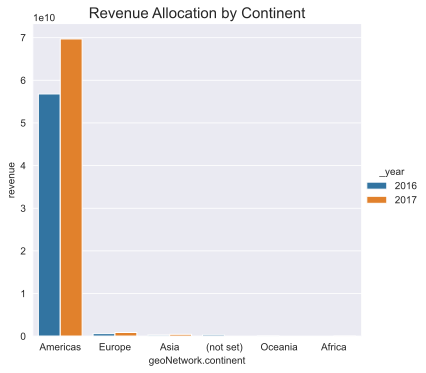

In [67]:
sns.factorplot(x= 'geoNetwork.continent', y= 'revenue', hue='_year', kind='bar',data= rev_user_cont[rev_user_cont['revenue']>0])
plt.title("Revenue Allocation by Continent", fontsize=15) 

#### Revenue Allocation by Country

Note: after 2017 Google store available outside USA

link: https://www.androidpolice.com/2017/03/09/feature-fluke-can-now-purchase-items-countrys-google-store/


In [68]:
rev_user_country=(
    sample_train.filter(['fullVisitorId','geoNetwork.country','_year','_month','_day','revenue',])
    .groupby(['geoNetwork.country','_year'])
    .agg({"revenue": "sum"})
    .reset_index()
    .sort_values(['revenue'],ascending=False)
    .query("(revenue>= 0)")
    )

rev_user_country['logRevenue']=np.log(rev_user_country['revenue'])

rev_user_country

,geoNetwork.country,_year,revenue,logRevenue
330,United States,2017,6.778912e+10,24.939668
329,United States,2016,5.585982e+10,24.746111
54,Canada,2017,1.779110e+09,21.299379
33,Belgium,2017,5.732500e+08,20.166832
335,Venezuela,2016,5.200800e+08,20.069493
...,...,...,...,...
119,Guatemala,2017,0.000000e+00,-inf
118,Guatemala,2016,0.000000e+00,-inf
117,Guam,2017,0.000000e+00,-inf
116,Guam,2016,0.000000e+00,-inf


Percentual of usage per Country: 
United States     36268
India              5172
United Kingdom     3834
Vietnam            2559
Canada             2530
Germany            2037
Turkey             2023
Thailand           2005
Brazil             1986
Japan              1902
France             1525
Taiwan             1340
Mexico             1332
Australia          1252
Spain              1201
Russia             1155
Netherlands        1135
Italy              1120
Philippines         974
Poland              940
Indonesia           911
Singapore           787
Ireland             685
Malaysia            630
Romania             626
Name: geoNetwork.country, dtype: int64


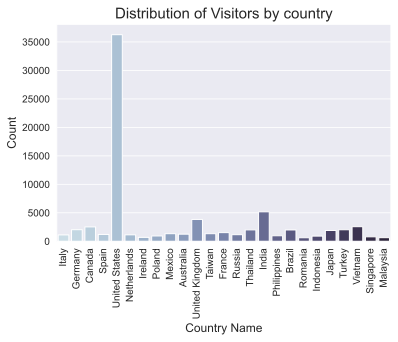

In [69]:
print("Percentual of usage per Country: ")
print(sample_train['geoNetwork.country'].value_counts()[:25] )

sns.countplot(sample_train[sample_train['geoNetwork.country']\
                       .isin(sample_train['geoNetwork.country']\
                             .value_counts()[:25].index.values)]['geoNetwork.country'], palette="ch:s=.25,rot=-.25")  
plt.title("Distribution of Visitors by country", fontsize=15) 
plt.xlabel("Country Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=90) 
plt.show() 

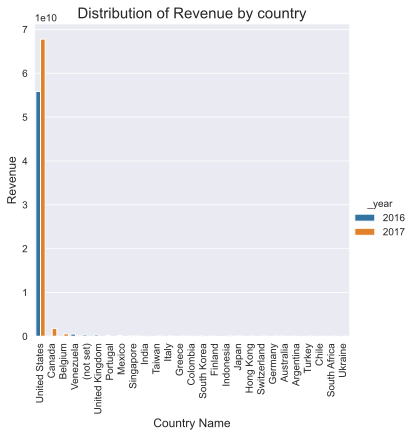

In [70]:
sns.factorplot(x= 'geoNetwork.country', y= 'revenue', hue='_year', kind='bar',data= rev_user_country[rev_user_country['revenue']>0])
plt.title("Revenue Allocation by Country", fontsize=15)
plt.title("Distribution of Revenue by country", fontsize=15) 
plt.xlabel("Country Name", fontsize=12) 
plt.ylabel("Revenue", fontsize=12) 
plt.xticks(rotation=90) 
plt.show() 

### Year: 

Distribution per Year: 
2017    47090
2016    43323
Name: _year, dtype: int64


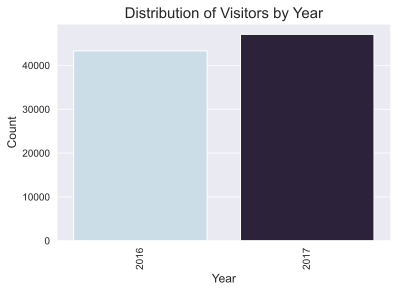

In [71]:
print("Distribution per Year: ")
print(sample_train['_year'].value_counts()[:25] )

import matplotlib.pyplot as plt
sns.countplot(sample_train[sample_train['_year']\
                       .isin(sample_train['_year']\
                             .value_counts()[:25].index.values)]['_year'], palette="ch:s=.25,rot=-.25") # It's a module to count the category's
plt.title("Distribution of Visitors by Year", fontsize=15) 
plt.xlabel("Year", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=90) 
plt.show() 

### Month:
When are most of transaction are made

Distribution per Month: 
11    11289
10     9655
12     7802
8      7677
7      7221
9      7185
3      7154
4      6684
1      6535
5      6533
6      6441
2      6237
Name: _month, dtype: int64


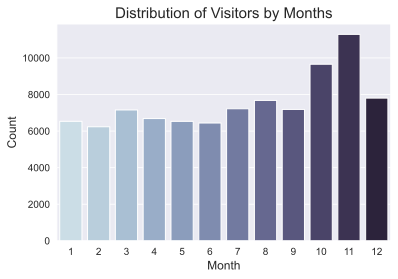

In [72]:
print("Distribution per Month: ")
print(sample_train['_month'].value_counts() )

import matplotlib.pyplot as plt
sns.countplot(sample_train[sample_train['_month']\
                       .isin(sample_train['_month']\
                             .value_counts()[:12].index.values)]['_month'], palette="ch:s=.25,rot=-.25") 
plt.title("Distribution of Visitors by Months", fontsize=15) 
plt.xlabel("Month", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=0) 
plt.show() 

### Days:


Distribution per Day: 
1     3217
17    3108
4     3108
16    3094
24    3079
20    3079
5     3071
21    3063
26    3051
15    3011
27    3000
28    2983
14    2977
19    2973
3     2969
2     2950
9     2948
6     2930
10    2901
18    2901
23    2897
7     2889
22    2878
8     2875
13    2869
25    2830
12    2822
11    2799
30    2765
29    2631
31    1745
Name: _day, dtype: int64


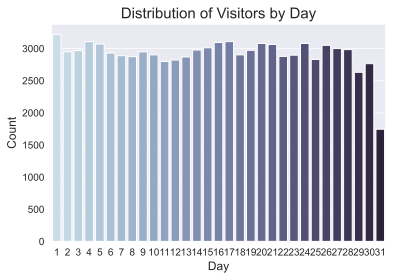

In [73]:
print("Distribution per Day: ")
print(sample_train['_day'].value_counts() )

import matplotlib.pyplot as plt
sns.countplot(sample_train[sample_train['_day']\
                       .isin(sample_train['_day']\
                             .value_counts().index.values)]['_day'], palette="ch:s=.25,rot=-.25") 
plt.title("Distribution of Visitors by Day", fontsize=15) 
plt.xlabel("Day", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=0) 
plt.show() 

### Weekdays：

Distribution per Weekday: 
1    14851
2    14720
3    14329
0    14055
4    12861
6     9887
5     9710
Name: _weekday, dtype: int64


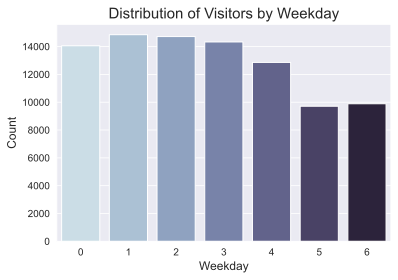

In [74]:
print("Distribution per Weekday: ")
print(sample_train['_weekday'].value_counts() )

import matplotlib.pyplot as plt
sns.countplot(sample_train[sample_train['_weekday']\
                       .isin(sample_train['_weekday']\
                             .value_counts().index.values)]['_weekday'], palette="ch:s=.25,rot=-.25") 
plt.title("Distribution of Visitors by Weekday", fontsize=15) 
plt.xlabel("Weekday", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=0) 
plt.show() 

In [75]:
#Q7 (0 means Monday):

cols = ["_month", "_day", "_weekday"]

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(cols):
    t = sample_train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:30][::-1], x = t.values[:15][::-1]))

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Day", "Visits: Month","Visits: Weekday"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=400, showlegend=False, title="Visits by Month/Day/Weekday")
iplot(fig)



## convert transaction revenue to float

sample_train["revenue"] = sample_train["revenue"].astype('float')

cols = ["_month","_day","_weekday"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Day", "Mean Revenue: Month","Mean Revenue: Weekday"], print_grid=False)

colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(cols):
    tmp = sample_train.groupby(col).agg({"revenue": "mean"}).reset_index().rename(columns={"revenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Mean Revenue by Month/Day/Weekday")
iplot(fig)


Some basic questions you want to find out about the dataset:

**Find the answers of these quesitons**

1. How many rows and columns are there in the dataset?
2. What features are there in the datasets?
3. What is the range of the dates in the dataset?
4. Any constant column? (column only has one value), And, why should we remove them?
5. What are the correlations between each feature and the target variable?
6. Which channelGrouping has the highest probability of conversion to purchase?
7. Any time-series trend in purchase pattern? e.g. which weekday has the highest purchase

In [76]:
# Q1: How many rows and columns are there in the dataset?
train.shape

(903653, 56)

In [77]:
#Q2:
print("Name of the columns are:", "\n", train.columns) 

Name of the columns are: 
 Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounc

In [78]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,903653.0,4.518260e+05,2.608623e+05,0.000000e+00,2.259130e+05,4.518260e+05,6.777390e+05,9.036520e+05
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitId,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
totals.visits,903653.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.hits,903653.0,4.596538e+00,9.641437e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.pageviews,903553.0,3.849764e+00,7.025274e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totals.bounces,450630.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.newVisits,703060.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [79]:
sum(train['totals.transactionRevenue'])

nan

In [80]:
train.describe(include=np.object).transpose()

,count,unique,top,freq
channelGrouping,903653,8,Organic Search,381561
fullVisitorId,903653,723803,1957458976293878100,262
sessionId,903653,902755,8299246600045303796_1476600549,2
socialEngagementType,903653,1,Not Socially Engaged,903653
device.browser,903653,54,Chrome,620364
device.browserVersion,903653,1,not available in demo dataset,903653
device.browserSize,903653,1,not available in demo dataset,903653
device.operatingSystem,903653,20,Windows,350072
device.operatingSystemVersion,903653,1,not available in demo dataset,903653
device.mobileDeviceBranding,903653,1,not available in demo dataset,903653


In [81]:
len(list(train))

56

In [82]:
list(train)

['Unnamed: 0',
 'channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'socialEngagementType',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.isMobile',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.networkDomain',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 '

In [83]:
#Q3: Date Range
print(sample_train['date'].min())
print(sample_train['date'].max())

2016-08-01 00:00:00
2017-08-01 00:00:00


In [84]:
# Q4: Constant Columns
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [85]:
len(const_cols)

19

In [87]:
train_copy = train.copy()

In [88]:
# Since the values are constant, we can just drop them from our feature list 
# and save some memory and time in our modeling process.
# train_copy = train.copy()
for i in const_cols:
    train_copy.drop(i, inplace = True, axis = 1)

In [89]:
print(len(train_copy.columns))

37


In [90]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(train_copy):
    train_copy["date"] = pd.to_datetime(train_copy["date"], format="%Y%m%d") # seting the column as pandas datetime
    train_copy["_weekday"] = train_copy['date'].dt.weekday #extracting week day
    train_copy["_day"] = train_copy['date'].dt.day # extracting day
    train_copy["_month"] = train_copy['date'].dt.month # extracting day
    train_copy["_year"] = train_copy['date'].dt.year # extracting day
    train_copy['_visitHour'] = (train_copy['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return train_copy #returning the df after the transformations

In [91]:
train_copy = date_process(train_copy) 

In [92]:
train_copy.dtypes

Unnamed: 0                                               int64
channelGrouping                                         object
date                                            datetime64[ns]
fullVisitorId                                           object
sessionId                                               object
visitId                                                  int64
visitNumber                                              int64
visitStartTime                                           int64
device.browser                                          object
device.operatingSystem                                  object
device.isMobile                                           bool
device.deviceCategory                                   object
geoNetwork.continent                                    object
geoNetwork.subContinent                                 object
geoNetwork.country                                      object
geoNetwork.region                                      

**Description of Attributes**:



In [186]:
#Q5: Correlation Matrix 


In [94]:
train_copy['totals.transactionRevenue'] = train_copy['totals.transactionRevenue'].astype(float)
train_copy['totals.hits'] = train_copy['totals.hits'].astype(float)
train_copy['totals.pageviews'] = train_copy['totals.pageviews'].astype(float)
train_copy['trafficSource.adwordsClickInfo.page'] = train_copy['trafficSource.adwordsClickInfo.page'].astype(float)
df_int = train_copy[['visitNumber',
                     'totals.transactionRevenue', 'totals.hits',
                    'totals.pageviews', 'trafficSource.adwordsClickInfo.page',
                    '_weekday', '_month', '_day', '_year',
                    '_visitHour']].copy()
df_int.head()

,visitNumber,totals.transactionRevenue,totals.hits,totals.pageviews,trafficSource.adwordsClickInfo.page,_weekday,_month,_day,_year,_visitHour
0,1,NaN,1.0,1.0,NaN,4,9,2,2016,23
1,1,NaN,1.0,1.0,NaN,4,9,2,2016,13
2,1,NaN,1.0,1.0,NaN,4,9,2,2016,9
3,1,NaN,1.0,1.0,NaN,4,9,2,2016,13
4,2,NaN,1.0,1.0,NaN,4,9,2,2016,21


<AxesSubplot:>

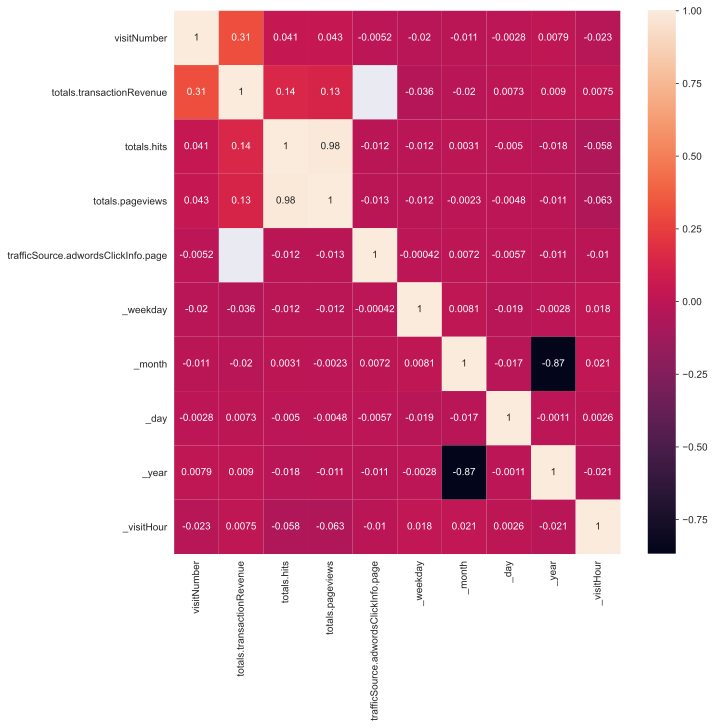

In [95]:
plt.subplots(figsize=(10,10))
sns.heatmap(df_int.corr(), annot = True)

In [96]:
df_cat = train_copy.drop(['visitNumber','visitStartTime',
                     'totals.hits',
                    'totals.pageviews', 'trafficSource.adwordsClickInfo.page',
                    '_weekday', '_month', '_day', '_year', 'date', 'visitId',
                    '_visitHour'], axis = 1)

In [97]:
df_cat.dtypes

Unnamed: 0                                        int64
channelGrouping                                  object
fullVisitorId                                    object
sessionId                                        object
device.browser                                   object
device.operatingSystem                           object
device.isMobile                                    bool
device.deviceCategory                            object
geoNetwork.continent                             object
geoNetwork.subContinent                          object
geoNetwork.country                               object
geoNetwork.region                                object
geoNetwork.metro                                 object
geoNetwork.city                                  object
geoNetwork.networkDomain                         object
totals.bounces                                  float64
totals.newVisits                                float64
totals.transactionRevenue                       

In [98]:
df_cat_no_target = df_cat.drop(['totals.transactionRevenue', 'device.isMobile'], axis = 1)

In [99]:
df_cat_no_target = df_cat_no_target.astype(str)

In [100]:
df_cat_no_target.dtypes

Unnamed: 0                                      object
channelGrouping                                 object
fullVisitorId                                   object
sessionId                                       object
device.browser                                  object
device.operatingSystem                          object
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork.networkDomain                        object
totals.bounces                                  object
totals.newVisits                                object
trafficSource.campaign                          object
trafficSource.source                            object
trafficSou

***Encoding for the categorical variables***

In [101]:
from sklearn.preprocessing import LabelEncoder
df_cat_no_target = df_cat_no_target.apply(LabelEncoder().fit_transform)

In [102]:
df_cat_no_target['totals.transactionRevenue'] = df_cat['totals.transactionRevenue']

In [103]:
df_cat_no_target.dtypes

Unnamed: 0                                        int32
channelGrouping                                   int32
fullVisitorId                                     int32
sessionId                                         int32
device.browser                                    int32
device.operatingSystem                            int32
device.deviceCategory                             int32
geoNetwork.continent                              int32
geoNetwork.subContinent                           int32
geoNetwork.country                                int32
geoNetwork.region                                 int32
geoNetwork.metro                                  int32
geoNetwork.city                                   int32
geoNetwork.networkDomain                          int32
totals.bounces                                    int32
totals.newVisits                                  int32
trafficSource.campaign                            int32
trafficSource.source                            

In [104]:
df_cat_no_target['totals.transactionRevenue'] = df_cat_no_target['totals.transactionRevenue'].fillna(0)

In [105]:
transaction = df_cat_no_target['totals.transactionRevenue']
channel = df_cat_no_target['channelGrouping']

In [106]:
from scipy.stats import pointbiserialr
pbc = pointbiserialr(channel, transaction)
print(pbc)

PointbiserialrResult(correlation=-0.006644355745465457, pvalue=2.680215548678763e-10)


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Referral'),
  Text(1, 0, '(Other)'),
  Text(2, 0, 'Paid Search'),
  Text(3, 0, 'Direct'),
  Text(4, 0, 'Display'),
  Text(5, 0, 'Organic Search'),
  Text(6, 0, 'Social')])

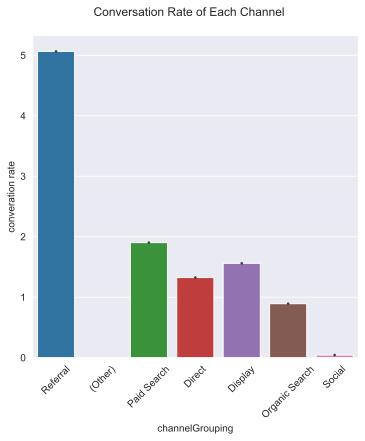

In [107]:
## Q6
sample_train_copy = sample_train.copy()
conditions = [(sample_train_copy['revenue'] > 0),
             (sample_train_copy['revenue'] <= 0)]
values = ['1', '0']
sample_train_copy['Buy_Or_Not'] = np.select(conditions, values)
sample_train_copy.to_csv('output.csv',index=False)
sample_train_copy['Buy_Or_Not'] = sample_train_copy['Buy_Or_Not'].astype("int")
sample_train_copy2 = sample_train_copy[sample_train_copy['Buy_Or_Not'] == 1]
sample_train_copy2_count = sample_train_copy2.groupby('channelGrouping')['Buy_Or_Not'].count()
sample_train_copy3 = sample_train_copy2.merge(sample_train_copy2_count, on='channelGrouping', how='left')
count2 = sample_train_copy.groupby('channelGrouping')['visitId'].count()
sample_train_copy4 = sample_train_copy3.merge(count2, on='channelGrouping', how='left')
sample_train_copy4['converation rate'] = sample_train_copy4['Buy_Or_Not_y'] / sample_train_copy4['visitId_y'] * 100
count = sample_train_copy4.groupby('channelGrouping')['converation rate'].max()
g = sns.catplot(x="channelGrouping", y="converation rate", kind='bar', 
                order = ['Referral','(Other)', 'Paid Search',
                         'Direct', 'Display','Organic Search',
                         'Social'], ci=False, data=sample_train_copy4)
g.fig.suptitle('Conversation Rate of Each Channel', y=1.05);
plt.xticks(rotation=45)

In [108]:
count

channelGrouping
Affiliates        0.059595
Direct            1.324877
Display           1.560062
Organic Search    0.892295
Paid Search       1.901743
Referral          5.064011
Social            0.044014
Name: converation rate, dtype: float64

## Data cleaning 

In [109]:
# check how many unique values are present in each column of the data
column_names = sample_train.columns.to_list()
unique_value_columns=[]
for column in column_names:
    count = sample_train[column].nunique()
    if count==1:
        del sample_train[column]
        unique_value_columns.append(column)
print(unique_value_columns)

['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']


In [110]:
list(sample_train)

['Unnamed: 0',
 'channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'revenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.referralPath',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adContent',
 'trafficSource.campaignCode',
 '_weekday',
 '_day',
 '_month',
 '_year',
 '_visitHour',
 'logRevenue',
 'log1pRevenue']

### Missing Data Handling

In [111]:
train.isna().sum(axis = 0)

Unnamed: 0                                                0
channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                

**totals.pageviews**: replace N/A with 0

**totals.transactionRevenue**: replace N/A with 0

**totals.bounces**: replace N/A with 0

**totals.newVisits**: replace N/A with 0

**trafficSource.keyword**: drop it

**trafficSource.isTrueDirect**: enconding first, replace N/A with 0

**trafficSource.referralPath**: we might drop it

**trafficSource.adwordsClickInfo.page**: we might drop it 

**trafficSource.adwordsClickInfo.slot**: replace N/A with blank

**trafficSource.adwordsClickInfo.gclId**: we might drop it

**trafficSource.adwordsClickInfo.adNetworkType**: we might drop it

**trafficSource.adwordsClickInfo.isVideoAd**: we might drop it

**trafficSource.adContent**: we might drop it

**trafficSource.campaignCode**: we might drop it

In [112]:
rep_na_0 =['totals.pageviews', 'totals.bounces', 'totals.newVisits','totals.transactionRevenue']
drop_list = ['trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId',
             'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent', 'trafficSource.campaignCode']
encod = ['trafficSource.isTrueDirect']
rep_na_blank = ['trafficSource.adwordsClickInfo.slot']

In [113]:
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [114]:
train.dtypes

Unnamed: 0                                             int64
channelGrouping                                       object
date                                                   int64
fullVisitorId                                         object
sessionId                                             object
socialEngagementType                                  object
visitId                                                int64
visitNumber                                            int64
visitStartTime                                         int64
device.browser                                        object
device.browserVersion                                 object
device.browserSize                                    object
device.operatingSystem                                object
device.operatingSystemVersion                         object
device.isMobile                                         bool
device.mobileDeviceBranding                           object
device.mobileDeviceModel

In [115]:
for i in drop_list:
    train.drop(i, inplace = True, axis = 1)
print(len(train.columns))

48


In [116]:
for i in rep_na_0:
    train[i] = train[i].fillna(0)
print(len(train.columns))

48


In [117]:
for i in encod:
    train[i] = train[i].fillna(False).astype(int)
print(len(train.columns))


48


In [118]:
for i in rep_na_blank:
    train[i] = train[i].fillna('')
print(len(train.columns))

48


In [119]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]

for i in const_cols:
    train.drop(i, inplace = True, axis = 1)
print(len(train.columns))

29


In [120]:
train.describe(include=np.object).transpose()

,count,unique,top,freq
channelGrouping,903653,8,Organic Search,381561
fullVisitorId,903653,723803,1957458976293878100,262
sessionId,903653,902755,8299246600045303796_1476600549,2
device.browser,903653,54,Chrome,620364
device.operatingSystem,903653,20,Windows,350072
device.deviceCategory,903653,3,desktop,664479
geoNetwork.continent,903653,6,Americas,450377
geoNetwork.subContinent,903653,23,Northern America,390657
geoNetwork.country,903653,222,United States,364744
geoNetwork.region,903653,376,not available in demo dataset,508229


In [121]:
train.dtypes

Unnamed: 0                               int64
channelGrouping                         object
date                                     int64
fullVisitorId                           object
sessionId                               object
visitId                                  int64
visitNumber                              int64
visitStartTime                           int64
device.browser                          object
device.operatingSystem                  object
device.isMobile                           bool
device.deviceCategory                   object
geoNetwork.continent                    object
geoNetwork.subContinent                 object
geoNetwork.country                      object
geoNetwork.region                       object
geoNetwork.metro                        object
geoNetwork.city                         object
geoNetwork.networkDomain                object
totals.hits                              int64
totals.pageviews                       float64
totals.bounce

In [122]:
train['fullVisitorId'] = train['fullVisitorId'].astype(float)
train['sessionId'] = train['sessionId'].astype(float)

In [123]:
train.dtypes

Unnamed: 0                               int64
channelGrouping                         object
date                                     int64
fullVisitorId                          float64
sessionId                              float64
visitId                                  int64
visitNumber                              int64
visitStartTime                           int64
device.browser                          object
device.operatingSystem                  object
device.isMobile                           bool
device.deviceCategory                   object
geoNetwork.continent                    object
geoNetwork.subContinent                 object
geoNetwork.country                      object
geoNetwork.region                       object
geoNetwork.metro                        object
geoNetwork.city                         object
geoNetwork.networkDomain                object
totals.hits                              int64
totals.pageviews                       float64
totals.bounce

In [124]:
from sklearn.preprocessing import OneHotEncoder
one_hot_list = list(train.describe(include=np.object).transpose().index)
one_hot_list.remove('geoNetwork.networkDomain')
one_hot_list

['channelGrouping',
 'device.browser',
 'device.operatingSystem',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.adwordsClickInfo.slot']

In [125]:
import missingno as msno
msno.matrix(train)

<AxesSubplot:>

In [126]:
# if transactionRevenue is NA, it means 0
# sample_train['revenue']=sample_train['revenue'].fillna(0)
sample_train['logRevenue']=sample_train['logRevenue'].fillna(0)

In [127]:
sample_train.isna().sum(axis = 0)

Unnamed: 0                                          0
channelGrouping                                     0
date                                                0
fullVisitorId                                       0
sessionId                                           0
visitId                                             0
visitNumber                                         0
visitStartTime                                      0
device.browser                                      0
device.operatingSystem                              0
device.isMobile                                     0
device.deviceCategory                               0
geoNetwork.continent                                0
geoNetwork.subContinent                             0
geoNetwork.country                                  0
geoNetwork.region                                   0
geoNetwork.metro                                    0
geoNetwork.city                                     0
geoNetwork.networkDomain    

# Label Encoding:

In [128]:
from sklearn.preprocessing import LabelEncoder
def label_encode(df):
    encode_list = list(df.describe(include=np.object).transpose().index)
    data_label_encode = df[encode_list].apply(LabelEncoder().fit_transform)
    res = df
    for i in encode_list:
        res = res.drop(i,axis = 1)
    data_label_encode['visitId'] = df['visitId']
    merged = pd.merge(res,data_label_encode , on='visitId', how='outer')
    merged['logRevenue'] = np.log(merged['totals.transactionRevenue'])
    return merged

In [129]:
train_transformed = label_encode(train)

In [130]:
train_transformed.dtypes

Unnamed: 0                               int64
date                                     int64
fullVisitorId                          float64
sessionId                              float64
visitId                                  int64
visitNumber                              int64
visitStartTime                           int64
device.isMobile                           bool
totals.hits                              int64
totals.pageviews                       float64
totals.bounces                         float64
totals.newVisits                       float64
totals.transactionRevenue              float64
trafficSource.isTrueDirect               int32
channelGrouping                          int32
device.browser                           int32
device.operatingSystem                   int32
device.deviceCategory                    int32
geoNetwork.continent                     int32
geoNetwork.subContinent                  int32
geoNetwork.country                       int32
geoNetwork.re

In [131]:
train_transformed.isna().sum(axis = 0)

Unnamed: 0                             0
date                                   0
fullVisitorId                          0
sessionId                              0
visitId                                0
visitNumber                            0
visitStartTime                         0
device.isMobile                        0
totals.hits                            0
totals.pageviews                       0
totals.bounces                         0
totals.newVisits                       0
totals.transactionRevenue              0
trafficSource.isTrueDirect             0
channelGrouping                        0
device.browser                         0
device.operatingSystem                 0
device.deviceCategory                  0
geoNetwork.continent                   0
geoNetwork.subContinent                0
geoNetwork.country                     0
geoNetwork.region                      0
geoNetwork.metro                       0
geoNetwork.city                        0
geoNetwork.netwo

In [132]:
train_transformed

,Unnamed: 0,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.isMobile,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.isTrueDirect,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.adwordsClickInfo.slot,logRevenue
0,0,20160902,1.131660e+18,1.131660e+28,1472830385,1,1472830385,False,1,1.0,1.0,1.0,0.0,0,4,11,16,0,3,21,204,150,0,258,24932,0,149,5,0,-inf
1,1,20160902,3.773060e+17,3.773060e+27,1472880147,1,1472880147,False,1,1.0,1.0,1.0,0.0,0,4,16,7,0,5,1,12,375,93,648,6673,0,149,5,0,-inf
2,2,20160902,3.895546e+18,3.895546e+28,1472865386,1,1472865386,False,1,1.0,1.0,1.0,0.0,0,4,11,16,0,4,19,181,78,0,325,25841,0,149,5,0,-inf
3,3,20160902,4.763447e+18,4.763447e+28,1472881213,1,1472881213,False,1,1.0,1.0,1.0,0.0,0,4,46,6,0,3,16,94,375,93,648,25841,0,149,5,0,-inf
4,4,20160902,2.729444e+16,2.729444e+26,1472822600,2,1472822600,True,1,1.0,1.0,0.0,0.0,1,4,11,1,1,4,13,211,375,93,648,25841,0,149,5,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939506,903648,20170104,5.123779e+18,5.123779e+28,1483554750,1,1483554750,False,17,15.0,0.0,1.0,0.0,0,7,11,16,0,2,2,161,375,93,648,19523,0,378,6,0,-inf
939507,903649,20170104,7.231729e+18,7.231729e+28,1483543798,1,1483543798,True,18,13.0,0.0,1.0,0.0,0,7,11,1,1,3,18,182,375,93,648,25841,0,378,6,0,-inf
939508,903650,20170104,5.744577e+18,5.744577e+28,1483526434,1,1483526434,True,24,21.0,0.0,1.0,0.0,0,7,6,1,1,3,6,180,291,0,533,25841,0,378,6,0,-inf
939509,903651,20170104,2.709355e+18,2.709355e+28,1483592857,1,1483592864,False,24,22.0,0.0,1.0,0.0,0,7,11,16,0,3,16,94,375,93,648,25841,0,132,6,0,-inf


In [133]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,903653.0,4.518260e+05,2.608623e+05,0.000000e+00,2.259130e+05,4.518260e+05,6.777390e+05,9.036520e+05
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
fullVisitorId,903653.0,4.505845e+18,3.071128e+18,4.823595e+12,1.593048e+18,4.388191e+18,7.194903e+18,5.198308e+19
sessionId,903653.0,4.505845e+28,3.071128e+28,4.823595e+22,1.593048e+28,4.388191e+28,7.194903e+28,5.198308e+29
visitId,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
totals.hits,903653.0,4.596538e+00,9.641437e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.pageviews,903653.0,3.849338e+00,7.025002e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totals.bounces,903653.0,4.986759e-01,4.999985e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [134]:
train.columns.to_list()

['Unnamed: 0',
 'channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.slot']

In [135]:
train

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.slot
0,0,Organic Search,20160902,1.131660e+18,1.131660e+28,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,
1,1,Organic Search,20160902,3.773060e+17,3.773060e+27,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,
2,2,Organic Search,20160902,3.895546e+18,3.895546e+28,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,
3,3,Organic Search,20160902,4.763447e+18,4.763447e+28,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,
4,4,Organic Search,20160902,2.729444e+16,2.729444e+26,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1.0,1.0,0.0,0.0,(not set),google,organic,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,903648,Social,20170104,5.123779e+18,5.123779e+28,1483554750,1,1483554750,Chrome,Windows,False,desktop,Americas,Caribbean,Puerto Rico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prtc.net,17,15.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,
903649,903649,Social,20170104,7.231729e+18,7.231729e+28,1483543798,1,1483543798,Chrome,Android,True,mobile,Asia,Southern Asia,Sri Lanka,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,18,13.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,
903650,903650,Social,20170104,5.744577e+18,5.744577e+28,1483526434,1,1483526434,Android Webview,Android,True,mobile,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,unknown.unknown,24,21.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,
903651,903651,Social,20170104,2.709355e+18,2.709355e+28,1483592857,1,1483592864,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,24,22.0,0.0,1.0,0.0,(not set),facebook.com,referral,0,


#### some features have more than 90% of missing values, what should you do? 

### Re-formatting

Since you are going to predict the sum of revenue and take natural log in the individual level, you have two ways to do that:

1. you can predict the sum of revenue for each customer directly by re-organizing the dataset into a format where each row represents a customer
2. you can predict the transaction revenue for each transaction and then aggregate the predicted revenue in individual level

In [136]:
date_process(train)

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.slot,_weekday,_day,_month,_year,_visitHour
0,0,Organic Search,2016-09-02,1.131660e+18,1.131660e+28,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,,4,2,9,2016,23
1,1,Organic Search,2016-09-02,3.773060e+17,3.773060e+27,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,,4,2,9,2016,13
2,2,Organic Search,2016-09-02,3.895546e+18,3.895546e+28,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,,4,2,9,2016,9
3,3,Organic Search,2016-09-02,4.763447e+18,4.763447e+28,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1.0,1.0,1.0,0.0,(not set),google,organic,0,,4,2,9,2016,13
4,4,Organic Search,2016-09-02,2.729444e+16,2.729444e+26,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1.0,1.0,0.0,0.0,(not set),google,organic,1,,4,2,9,2016,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,903648,Social,2017-01-04,5.123779e+18,5.123779e+28,1483554750,1,1483554750,Chrome,Windows,False,desktop,Americas,Caribbean,Puerto Rico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prtc.net,17,15.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,,2,4,1,2017,2
903649,903649,Social,2017-01-04,7.231729e+18,7.231729e+28,1483543798,1,1483543798,Chrome,Android,True,mobile,Asia,Southern Asia,Sri Lanka,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,18,13.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,,2,4,1,2017,23
903650,903650,Social,2017-01-04,5.744577e+18,5.744577e+28,1483526434,1,1483526434,Android Webview,Android,True,mobile,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,unknown.unknown,24,21.0,0.0,1.0,0.0,(not set),youtube.com,referral,0,,2,4,1,2017,18
903651,903651,Social,2017-01-04,2.709355e+18,2.709355e+28,1483592857,1,1483592864,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,24,22.0,0.0,1.0,0.0,(not set),facebook.com,referral,0,,2,4,1,2017,13


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Step 3: Modeling

<font color=red>things you need to consider:</font>

1. a proper metric in this business scenario
2. algorithms which can handle skewed target distribution, or post-processing approach
3. how you split dataset into training and validation

In [138]:
from datetime import datetime

# This function is to extract date features
def date_process(data_temp):
    df = data_temp.copy()
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    date_df = df
    np.shape(df)
    return date_df #returning the df after the transformations

def na_drop_clean(data_temp):
    
    rep_na_0 =['totals.pageviews', 'totals.bounces', 'totals.newVisits','totals.transactionRevenue','converation rate']
    drop_list = ['trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId',
             'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent', 'trafficSource.campaignCode',
                'visitId_x','Buy_Or_Not_x', 'visitId_y', 'Buy_Or_Not_y']
    encod = ['trafficSource.isTrueDirect']
    rep_na_blank = ['trafficSource.adwordsClickInfo.slot']
    const_cols = [c for c in data_temp.columns if data_temp[c].nunique(dropna=False)==1 ]
    df = data_temp.copy()
    for i in drop_list:
        df.drop(i, inplace = True, axis = 1)
    for i in rep_na_0:
        df[i] = df[i].fillna(0)
    for i in encod:
        df[i] = df[i].fillna(False).astype(int)
    for i in rep_na_blank:
        df[i] = df[i].fillna('')
    for i in const_cols:
        df.drop(i, inplace = True, axis = 1)
    df['fullVisitorId'] = df['fullVisitorId'].astype(float)
    df['sessionId'] = df['sessionId'].astype(float)
    np.shape(df)
    # df.describe(include=np.object).transpose()
    return df
# this function has no return    ???

from sklearn.preprocessing import LabelEncoder
def label_encode(data_temp):
    res = data_temp.copy()
    encode_list = list(res.describe(include=np.object).transpose().index)
    data_label_encode = res[encode_list].apply(LabelEncoder().fit_transform)
    for i in encode_list:
        res = res.drop(i,axis = 1)
    data_label_encode['Unnamed: 0'] = res['Unnamed: 0']
    merged = pd.merge(res,data_label_encode , on='Unnamed: 0', how='outer')
    #merged['logRevenue'] = np.log(merged['totals.transactionRevenue'])
    np.shape(merged)
    return merged

In [139]:
def one_click(df):
    res = date_process(df)
    res = na_drop_clean(res)
    res = label_encode(res)
    return res

In [140]:
def label_encode_test(data_temp):
    res = data_temp.copy()
    encode_list = list(res.describe(include=np.object).transpose().index)
    data_label_encode = res[encode_list].apply(LabelEncoder().fit_transform)
    for i in encode_list:
        res = res.drop(i,axis = 1)
    data_label_encode['Unnamed: 0'] = res['Unnamed: 0']
    merged = pd.merge(res,data_label_encode , on='Unnamed: 0', how='outer')
    return merged

def na_drop_clean_test(data_temp):
    rep_na_0 =['totals.pageviews', 'totals.bounces', 'totals.newVisits']
    drop_list = ['trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId',
             'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent']
    encod = ['trafficSource.isTrueDirect']
    rep_na_blank = ['trafficSource.adwordsClickInfo.slot']
    const_cols = [c for c in data_temp.columns if data_temp[c].nunique(dropna=False)==1 ]
    df = data_temp.copy()
    for i in drop_list:
        df.drop(i, inplace = True, axis = 1)
    for i in rep_na_0:
        df[i] = df[i].fillna(0)
    for i in encod:
        df[i] = df[i].fillna(False).astype(int)
    for i in rep_na_blank:
        df[i] = df[i].fillna('')
    for i in const_cols:
        df.drop(i, inplace = True, axis = 1)
    df['fullVisitorId'] = df['fullVisitorId'].astype(float)
    df['sessionId'] = df['sessionId'].astype(float)
    np.shape(df)
    # df.describe(include=np.object).transpose()
    return df
def one_click_test(df):
    res = date_process(df)
    res = na_drop_clean_test(res)
    res = label_encode_test(res)
    return res

In [148]:
train = pd.read_csv('C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\train_local_copy.csv')
data = train.copy()

In [149]:
data.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not av

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Referral'),
  Text(1, 0, 'Display'),
  Text(2, 0, 'Paid Search'),
  Text(3, 0, 'Direct'),
  Text(4, 0, 'Organic Search'),
  Text(5, 0, 'Social'),
  Text(6, 0, '(Other)')])

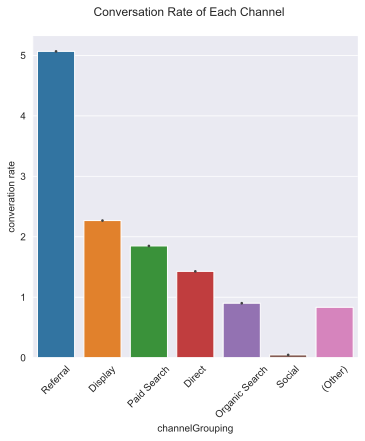

In [152]:
## Q6
sample_train_copy = data.copy()
conditions = [(sample_train_copy['totals.transactionRevenue'] > 0),
             (sample_train_copy['totals.transactionRevenue'] <= 0)]
values = ['1', '0']
sample_train_copy['Buy_Or_Not'] = np.select(conditions, values)
sample_train_copy.to_csv('output.csv',index=False)
sample_train_copy['Buy_Or_Not'] = sample_train_copy['Buy_Or_Not'].astype("int")
sample_train_copy2 = sample_train_copy[sample_train_copy['Buy_Or_Not'] == 1]
sample_train_copy2_count = sample_train_copy2.groupby('channelGrouping')['Buy_Or_Not'].count()
sample_train_copy3 = sample_train_copy2.merge(sample_train_copy2_count, on='channelGrouping', how='left')
count2 = sample_train_copy.groupby('channelGrouping')['visitId'].count()
sample_train_copy4 = sample_train_copy3.merge(count2, on='channelGrouping', how='left')
sample_train_copy4['converation rate'] = sample_train_copy4['Buy_Or_Not_y'] / sample_train_copy4['visitId_y'] * 100


count = sample_train_copy4.groupby('channelGrouping')['converation rate'].max()

g = sns.catplot(x="channelGrouping", y="converation rate", kind='bar', 
                order = ['Referral','Display', 'Paid Search',
                         'Direct','Organic Search',
                         'Social','(Other)'], ci=False, data=sample_train_copy4)
g.fig.suptitle('Conversation Rate of Each Channel', y=1.05);
plt.xticks(rotation=45)

In [153]:
data1=pd.merge(data,sample_train_copy4,  how='outer')
data1.describe()

,Unnamed: 0,date,visitId,visitNumber,visitStartTime,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.adwordsClickInfo.page,visitId_x,Buy_Or_Not_x,Buy_Or_Not_y,visitId_y,converation rate
count,903653.000000,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,903653.0,903653.000000,903553.000000,450630.0,703060.0,1.151500e+04,21460.000000,1.151500e+04,11515.0,11515.000000,11515.000000,11515.000000
mean,451826.000000,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.0,4.596538,3.849764,1.0,1.0,1.337448e+08,1.008108,1.485876e+09,1.0,3859.871038,190800.357360,2.962322
std,260862.295738,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.0,9.641437,7.025274,0.0,0.0,4.482852e+08,0.173584,9.308961e+06,0.0,1545.619166,127476.044584,1.966658
min,0.000000,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,1.0,1.000000,1.000000,1.0,1.0,1.000000e+04,1.000000,1.470046e+09,1.0,1.000000,120.000000,0.045994
25%,225913.000000,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,1.0,1.000000,1.000000,1.0,1.0,2.493000e+07,1.000000,1.478054e+09,1.0,3438.000000,104838.000000,0.901035
50%,451826.000000,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,1.0,2.000000,1.000000,1.0,1.0,4.945000e+07,1.000000,1.485554e+09,1.0,3438.000000,104838.000000,1.847903
75%,677739.000000,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.0,4.000000,4.000000,1.0,1.0,1.076550e+08,1.000000,1.493948e+09,1.0,5311.000000,381561.000000,5.065911
max,903652.000000,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.0,500.000000,469.000000,1.0,1.0,2.312950e+10,14.000000,1.501652e+09,1.0,5311.000000,381561.000000,5.065911


In [154]:
new_train = one_click(data1)
new_train.describe()

,Unnamed: 0,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.isTrueDirect,converation rate,_weekday,_day,_month,_year,_visitHour,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.adwordsClickInfo.slot
count,903653.000000,9.036530e+05,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,451826.000000,4.505845e+18,4.505845e+28,1.485007e+09,2.264897,1.485007e+09,4.596538,3.849338,0.498676,0.778020,1.704273e+06,0.303219,0.037748,2.735183,15.697570,6.987671,2016.517079,10.837112,4.632267,18.010335,10.917403,0.298370,2.716869,13.310106,159.462688,274.227521,65.756281,502.477715,12578.873023,0.187077,188.298400,4.456896,0.046938
std,260862.295738,3.071128e+18,3.071128e+28,9.022124e+06,9.283735,9.022124e+06,9.641437,7.025002,0.499999,0.415578,5.277866e+07,0.459649,0.399598,1.929072,8.823674,3.484576,0.499708,7.395881,1.774791,12.093815,6.249205,0.526058,0.885558,4.678611,66.633487,134.902035,38.616022,205.030135,11024.723154,1.022187,127.869576,2.076703,0.301854
min,0.000000,4.823595e+12,4.823595e+22,1.470035e+09,1.000000,1.470035e+09,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225913.000000,1.593048e+18,1.593048e+28,1.477561e+09,1.000000,1.477561e+09,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,8.000000,4.000000,2016.000000,4.000000,4.000000,11.000000,7.000000,0.000000,2.000000,12.000000,97.000000,145.000000,34.000000,366.000000,0.000000,0.000000,149.000000,5.000000,0.000000
50%,451826.000000,4.388191e+18,4.388191e+28,1.483949e+09,1.000000,1.483949e+09,2.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,3.000000,16.000000,7.000000,2017.000000,10.000000,4.000000,11.000000,16.000000,0.000000,2.000000,12.000000,204.000000,375.000000,93.000000,648.000000,10714.000000,0.000000,149.000000,5.000000,0.000000
75%,677739.000000,7.194903e+18,7.194903e+28,1.492759e+09,1.000000,1.492759e+09,4.000000,4.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,4.000000,23.000000,10.000000,2017.000000,18.000000,7.000000,20.000000,16.000000,1.000000,3.000000,16.000000,212.000000,375.000000,93.000000,648.000000,24939.000000,0.000000,311.000000,6.000000,0.000000
max,903652.000000,5.198308e+19,5.198308e+29,1.501657e+09,395.000000,1.501657e+09,500.000000,469.000000,1.000000,1.000000,2.312950e+10,1.000000,5.065911,6.000000,31.000000,12.000000,2017.000000,23.000000,7.000000,53.000000,19.000000,2.000000,5.000000,22.000000,221.000000,375.000000,93.000000,648.000000,28063.000000,9.000000,379.000000,6.000000,2.000000


In [155]:
# upload test
test = load_df('C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\test.csv',nrows=None)
test=test.to_csv(r'C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\test1111.csv')
test = pd.read_csv('C:\\Users\\Jovan Trajceski\\OneDrive - Hong Kong Baptist University\\Semester 2\\ECON7940 Data-driven Decision Making\\test1111.csv')

test = test.copy()

Loaded test.csv. Shape: (804684, 53)


In [156]:
new_test = one_click_test(test)
new_test

,Unnamed: 0,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.isMobile,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.isTrueDirect,_weekday,_day,_month,_year,_visitHour,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.adwordsClickInfo.slot
0,0,2017-10-16,6.167871e+18,6.167871e+28,1508151024,2,1508151024,False,4,4.0,0.0,0.0,1,0,16,10,2017,18,4,31,7,0,3,16,170,0,0,0,15079,4,124,5,0
1,1,2017-10-16,6.436976e+17,6.436976e+27,1508175522,1,1508175522,False,5,5.0,1.0,0.0,0,0,16,10,2017,1,4,31,18,0,4,19,179,17,0,726,18749,4,124,5,0
2,2,2017-10-16,6.059384e+18,6.059384e+28,1508143220,1,1508143220,False,7,7.0,1.0,0.0,0,0,16,10,2017,16,4,31,7,0,4,22,66,375,108,731,19807,4,124,5,0
3,3,2017-10-16,2.376720e+18,2.376720e+28,1508193530,1,1508193530,True,8,4.0,1.0,0.0,0,0,16,10,2017,6,4,57,21,1,2,12,210,56,92,417,0,4,124,5,0
4,4,2017-10-16,2.314545e+18,2.314545e+28,1508217442,1,1508217442,False,9,4.0,1.0,0.0,0,0,16,10,2017,13,4,57,7,0,2,12,210,56,92,580,0,4,124,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804679,804679,2018-04-21,9.084226e+18,9.084226e+28,1524358436,2,1524358436,False,33,26.0,0.0,0.0,0,5,21,4,2018,8,7,36,18,0,2,12,210,147,16,140,0,4,322,6,0
804680,804680,2018-04-21,6.146210e+18,6.146210e+28,1524317728,1,1524317728,True,36,34.0,1.0,0.0,0,5,21,4,2018,21,7,31,1,1,2,15,211,375,108,731,4288,4,322,6,0
804681,804681,2018-04-21,7.484544e+18,7.484544e+28,1524364725,1,1524364725,True,53,35.0,1.0,0.0,0,5,21,4,2018,10,7,58,21,1,2,12,35,375,108,731,19858,4,218,6,0
804682,804682,2018-04-21,2.915966e+18,2.915966e+28,1524330416,1,1524330416,True,58,34.0,1.0,0.0,0,5,21,4,2018,1,7,59,1,1,4,13,94,83,0,191,14117,4,322,6,0


In [157]:
non_relevant = ['Unnamed: 0',"visitNumber",'fullVisitorId','visitId',"date", "sessionId", "visitStartTime"]

In [158]:
train = new_train.copy()
test = new_test.copy()

for i in non_relevant:
    train.drop(i, inplace = True, axis = 1)
    test.drop(i, inplace = True, axis = 1)


In [167]:
train["totals.hits"] = train["totals.hits"].astype(float)
train["trafficSource.isTrueDirect"] = train["trafficSource.isTrueDirect"].astype(float)
train["_weekday"] = train["_weekday"].astype(float)
train["_day"] = train["_day"].astype(float)
train["_month"] = train["_month"].astype(float)
train["_year"] = train["_year"].astype(float)
train["_visitHour"] = train["_visitHour"].astype(float)
train["channelGrouping"] = train["channelGrouping"].astype(float)
train["device.browser"] = train["device.browser"].astype(float)
train["device.operatingSystem"] = train["device.operatingSystem"].astype(float)
train["device.deviceCategory"] = train["device.deviceCategory"].astype(float)
train["geoNetwork.continent"] = train["geoNetwork.continent"].astype(float)
train["geoNetwork.subContinent"] = train["geoNetwork.subContinent"].astype(float)
train["geoNetwork.country"] = train["geoNetwork.country"].astype(float)
train["geoNetwork.region"] = train["geoNetwork.region"].astype(float)
train["geoNetwork.metro"] = train["geoNetwork.metro"].astype(float)
train["geoNetwork.city"] = train["geoNetwork.city"].astype(float)
train["geoNetwork.networkDomain"] = train["geoNetwork.networkDomain"].astype(float)
train["trafficSource.campaign"] = train["trafficSource.campaign"].astype(float)
train["trafficSource.source"] = train["trafficSource.source"].astype(float)
train["trafficSource.medium"] = train["trafficSource.medium"].astype(float)
train["trafficSource.adwordsClickInfo.slot"] = train["trafficSource.adwordsClickInfo.slot"].astype(float)
train["device.isMobile"] = train["device.isMobile"].astype(float)

In [168]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   device.isMobile                      903653 non-null  float64
 1   totals.hits                          903653 non-null  float64
 2   totals.pageviews                     903653 non-null  float64
 3   totals.bounces                       903653 non-null  float64
 4   totals.newVisits                     903653 non-null  float64
 5   totals.transactionRevenue            903653 non-null  float64
 6   trafficSource.isTrueDirect           903653 non-null  float64
 7   converation rate                     903653 non-null  float64
 8   _weekday                             903653 non-null  float64
 9   _day                                 903653 non-null  float64
 10  _month                               903653 non-null  float64
 11  _year        

In [169]:
test_df_model_columns = test.copy()

In [170]:
train.shape

(903653, 28)

In [171]:
# other try # 70% train and 30% CV
632557/903653

0.6999998893380535

In [172]:
# other try # 70% train and 30% CV

train_df_model_columns_train = train[:632557]
train_df_model_columns_cv = train[632558:]
train_X = train_df_model_columns_train.drop(columns=['totals.transactionRevenue','converation rate'])
train_Y = np.log1p(train_df_model_columns_train['totals.transactionRevenue'].values)
cv_X = train_df_model_columns_cv.drop(columns=['totals.transactionRevenue','converation rate'])
cv_Y = np.log1p(train_df_model_columns_cv['totals.transactionRevenue'].values)

In [173]:
train_X.dtypes

device.isMobile                        float64
totals.hits                            float64
totals.pageviews                       float64
totals.bounces                         float64
totals.newVisits                       float64
trafficSource.isTrueDirect             float64
_weekday                               float64
_day                                   float64
_month                                 float64
_year                                  float64
_visitHour                             float64
channelGrouping                        float64
device.browser                         float64
device.operatingSystem                 float64
device.deviceCategory                  float64
geoNetwork.continent                   float64
geoNetwork.subContinent                float64
geoNetwork.country                     float64
geoNetwork.region                      float64
geoNetwork.metro                       float64
geoNetwork.city                        float64
geoNetwork.ne

In [176]:

test_df_model_columns["totals.hits"] = test_df_model_columns["totals.hits"].astype(float)
test_df_model_columns["totals.pageviews"] = test_df_model_columns["totals.pageviews"].astype(float)
test_df_model_columns["totals.newVisits"] = test_df_model_columns["totals.newVisits"].astype(float)
test_df_model_columns["totals.bounces"] = test_df_model_columns["totals.bounces"].astype(float)
test_df_model_columns["trafficSource.isTrueDirect"] = test_df_model_columns["trafficSource.isTrueDirect"].astype(float)
test_df_model_columns["_weekday"] = test_df_model_columns["_weekday"].astype(float)
test_df_model_columns["_day"] = test_df_model_columns["_day"].astype(float)
test_df_model_columns["_month"] = test_df_model_columns["_month"].astype(float)
test_df_model_columns["_year"] = test_df_model_columns["_year"].astype(float)
test_df_model_columns["_visitHour"] = test_df_model_columns["_visitHour"].astype(float)
test_df_model_columns["channelGrouping"] = test_df_model_columns["channelGrouping"].astype(float)
test_df_model_columns["device.browser"] = test_df_model_columns["device.browser"].astype(float)
test_df_model_columns["device.operatingSystem"] = test_df_model_columns["device.operatingSystem"].astype(float)
test_df_model_columns["device.deviceCategory"] = test_df_model_columns["device.deviceCategory"].astype(float)
test_df_model_columns["geoNetwork.continent"] = test_df_model_columns["geoNetwork.continent"].astype(float)
test_df_model_columns["geoNetwork.subContinent"] = test_df_model_columns["geoNetwork.subContinent"].astype(float)
test_df_model_columns["geoNetwork.country"] = test_df_model_columns["geoNetwork.country"].astype(float)
test_df_model_columns["geoNetwork.region"] = test_df_model_columns["geoNetwork.region"].astype(float)
test_df_model_columns["geoNetwork.metro"] = test_df_model_columns["geoNetwork.metro"].astype(float)
test_df_model_columns["geoNetwork.city"] = test_df_model_columns["geoNetwork.city"].astype(float)
test_df_model_columns["geoNetwork.networkDomain"] = test_df_model_columns["geoNetwork.networkDomain"].astype(float)
test_df_model_columns["trafficSource.campaign"] = test_df_model_columns["trafficSource.campaign"].astype(float)
test_df_model_columns["trafficSource.source"] = test_df_model_columns["trafficSource.source"].astype(float)
test_df_model_columns["trafficSource.medium"] = test_df_model_columns["trafficSource.medium"].astype(float)
test_df_model_columns["trafficSource.adwordsClickInfo.slot"] = test_df_model_columns["trafficSource.adwordsClickInfo.slot"].astype(float)
test_df_model_columns["device.isMobile"] = test_df_model_columns["device.isMobile"].astype(float)


In [178]:
test_df_model_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804684 entries, 0 to 804683
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   device.isMobile                      804684 non-null  float64
 1   totals.hits                          804684 non-null  float64
 2   totals.pageviews                     804684 non-null  float64
 3   totals.newVisits                     804684 non-null  float64
 4   totals.bounces                       804684 non-null  float64
 5   trafficSource.isTrueDirect           804684 non-null  float64
 6   _weekday                             804684 non-null  float64
 7   _day                                 804684 non-null  float64
 8   _month                               804684 non-null  float64
 9   _year                                804684 non-null  float64
 10  _visitHour                           804684 non-null  float64
 11  channelGroupi

In [179]:
train_Y = pd.DataFrame(train_Y)

In [180]:
import statsmodels.api as sm
model = sm.OLS(train_Y, train_X.astype(float)).fit()
predictions = model.predict(train_X.astype(float)) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      0   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.192
Method:                 Least Squares   F-statistic:                              5797.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                        0.00
Time:                        12:36:57   Log-Likelihood:                     -1.2715e+06
No. Observations:              632557   AIC:                                  2.543e+06
Df Residuals:                  632531   BIC:                                  2.543e+06
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
device.isMobile                        -0.1492      0.016     -9.119      0.000      -0.181      -0.117
totals.hits                            -0.1093      0.001    -83.833      0.000      -0.112      -0.107
totals.pageviews                        0.2674      0.002    146.845      0.000       0.264       0.271
totals.bounces                          0.3238      0.005     63.435      0.000       0.314       0.334
totals.newVisits                       -0.1876      0.009    -20.925      0.000      -0.205      -0.170
trafficSource.isTrueDirect              0.1518      0.010     14.475      0.000       0.131       0.172
_weekday                               -0.0032      0.001     -2.617      0.009      -0.006      -0.001
_day                                   -0.0003      0.000     -1.136      0.256      -0.001       0.000
_month                                 -0.0042      0.001     -6.214      0.000      -0.006      -0.003
_year                                  -0.0002   1.23e-05    -15.476      0.000      -0.000      -0.000
_visitHour                             -0.0019      0.000     -6.082      0.000      -0.003      -0.001
channelGrouping                         0.0352      0.005      7.531      0.000       0.026       0.044
device.browser                          0.0002      0.000      0.755      0.450      -0.000       0.001
device.operatingSystem                 -0.0059      0.000    -15.235      0.000      -0.007      -0.005
device.deviceCategory                   0.0100      0.014      0.740      0.459      -0.017       0.037
geoNetwork.continent                   -0.0399      0.003    -13.633      0.000      -0.046      -0.034
geoNetwork.subContinent                 0.0004      0.001      0.837      0.402      -0.001       0.001
geoNetwork.country                      0.0008   3.86e-05     21.433      0.000       0.001       0.001
geoNetwork.region                       0.0002   2.52e-05      6.739      0.000       0.000       0.000
geoNetwork.metro                        0.0002      0.000      1.814      0.070   -1.62e-05       0.000
geoNetwork.city                        -0.0001   2.23e-05     -6.648      0.000      -0.000      -0.000
geoNetwork.networkDomain            -2.238e-06   2.22e-07    -10.091      0.000   -2.67e-06    -1.8e-06
trafficSource.campaign                  0.0094      0.003      3.444      0.001       0.004       0.015
trafficSource.source                    0.0002   5.74e-05      4.128      0.000       0.000       0.000
trafficSource.medium                   -0.0016      0.003     -0.592      0.554      -0.007       0.004
trafficSource.adwordsClickInfo.slot    -0.0678      0.009     -7.317    

<AxesSubplot:>

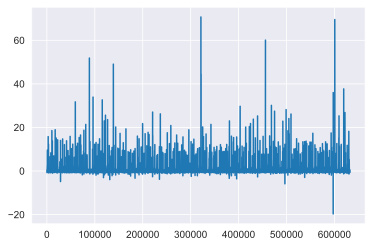

In [181]:
predictions.plot()

In [182]:
import lightgbm as lightGBM 

#about parameters of lightgbm --- https://lightgbm.readthedocs.io/en/latest/Parameters.html

lightGBM_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 100, "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9,"bagging_seed" : 2019,"use_best_model":True,"colsample_bytree":0.9}


lightGBM_train = lightGBM.Dataset(train_X, label=train_Y)
lightGBM_crossVal = lightGBM.Dataset(cv_X, label=cv_Y)
lightGBM_model = lightGBM.train(lightGBM_params, lightGBM_train, 700, valid_sets=[lightGBM_crossVal], early_stopping_rounds=150, verbose_eval=50)



Training until validation scores don't improve for 150 rounds
[50]	valid_0's rmse: 1.72155
[100]	valid_0's rmse: 1.66003
[150]	valid_0's rmse: 1.6435
[200]	valid_0's rmse: 1.63709
[250]	valid_0's rmse: 1.63479
[300]	valid_0's rmse: 1.63336
[350]	valid_0's rmse: 1.63257
[400]	valid_0's rmse: 1.63188
[450]	valid_0's rmse: 1.63166
[500]	valid_0's rmse: 1.63119
[550]	valid_0's rmse: 1.63114
[600]	valid_0's rmse: 1.63098
[650]	valid_0's rmse: 1.63114
[700]	valid_0's rmse: 1.6314
Did not meet early stopping. Best iteration is:
[597]	valid_0's rmse: 1.63095


In [183]:
prediction = lightGBM_model.predict(test_df_model_columns, num_iteration=lightGBM_model.best_iteration)
final_df = pd.DataFrame({"fullVisitorId":new_test['fullVisitorId']})
prediction[prediction<0] = 0

final_df["PredictedLogRevenue"] = np.expm1(prediction)

# log(x+y) != logx + logy

final_df = final_df.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
final_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

final_df["PredictedLogRevenue"] = np.log1p(final_df["PredictedLogRevenue"])

In [184]:
final_df.head()

,fullVisitorId,PredictedLogRevenue
0,2.596787e+11,0.566694
1,3.038793e+12,0.000000
2,9.663019e+12,0.000000
3,1.043846e+13,0.000000
4,1.099298e+13,0.049523


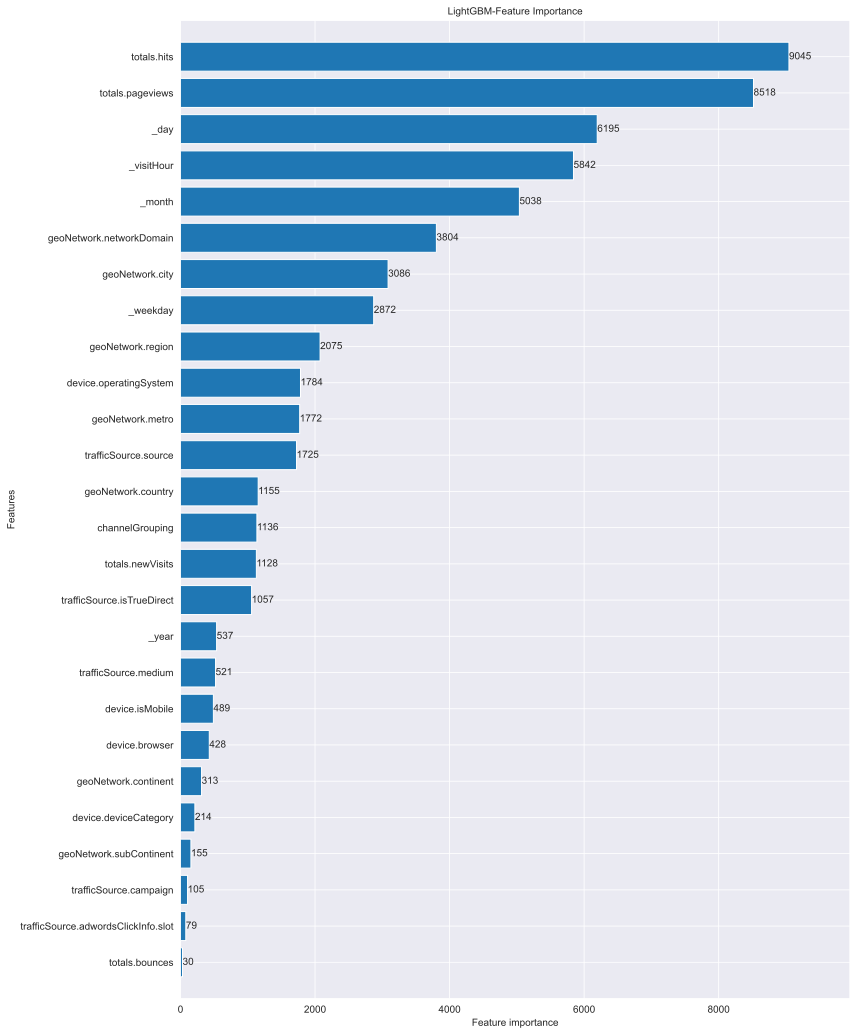

In [185]:
# GBM - Feature Importance chart

fig, ax = plt.subplots(figsize=(12,18))
lightGBM.plot_importance(lightGBM_model, max_num_features=30, height=0.8, ax=ax)
plt.title("LightGBM-Feature Importance", fontsize=10)
plt.show()